Below is an FSM with no outlier removal. 

In [1]:
import sys
sys.path.append('../..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.cleaning import prep_high_school_dataframe
from src.cleaning import isolate_numeric_columns, isolate_numeric_rates, filter_cwoption_special_ed
from src.cps_model import cv_feature_set

from sklearn.model_selection import cross_val_predict

%load_ext autoreload
%autoreload 2

The function below isolates high schools and drops high schools with no graduation rates or student counts.

In [2]:
sy_1819_hs = prep_high_school_dataframe('../../data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Profile_Information_SY1819.csv',
                     '../../data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Progress_Reports_SY1819.csv')

0 Student Count
2 schools
15     ENGLEWOOD STEM HS
582       YCCS - VIRTUAL
Name: Short_Name_sp, dtype: object
All 0 Student Count Schools Dropped
0 Graduation Rate
2 schools
261    PATHWAYS - AVONDALE HS
343     NORTHSIDE LEARNING HS
Name: Short_Name_sp, dtype: object
##########
NA Graduation Rates
38 schools
All 0/NA Graduation Rate Schools Dropped


There are 134 CPS high schools left for modeling.

In [3]:
sy_1819_hs.shape

(134, 289)

The distribution of graduation rates has a left skew. 

Text(0.5, 0, 'Graduation Rate')

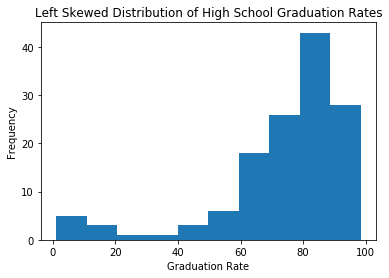

In [4]:
fig, ax = plt.subplots()
sy_1819_hs['Graduation_Rate_School'].plot(kind='hist', ax=ax)
ax.set_title('Left Skewed Distribution of High School Graduation Rates')
ax.set_xlabel('Graduation Rate')

# FSM

The FSM will be a dummy regressor that predicts the mean graduation rate.  

I will use the custom `print_cv_results` function, which implements 10-Fold cross-validation. 

In [5]:
from sklearn.dummy import DummyRegressor

dr = DummyRegressor()

grad_rates = sy_1819_hs['Graduation_Rate_School']
cv_feature_set(dr, sy_1819_hs,grad_rates)


##########Training##########
R2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0
RMSE
[20.38317219 21.77756795 21.60316791 20.5013475  21.2544558  20.72566739
 19.80205738 21.7709005  19.84019979 21.77752956]
Mean RMSE:  20.943606597039395
Standard Deviation RMSE:  0.7539762013674577


##########Test##########
R2
[-4.97391302e-03 -3.66797886e-04 -4.11280977e-02 -2.16059299e-04
 -4.28798892e-01 -1.69603487e-03 -2.53641968e-01 -4.72541779e-02
 -1.04069561e-01 -1.21243289e+00]
-0.20945783940467405
RMSE
[25.4336093  11.94302389 14.4339264  24.59948051 18.34222346 23.09430811
 29.98858818 10.97039573 29.5904806  11.12263294]
Mean RMSE:  19.95186691326086
Standard Deviation RMSE:  7.1481870370137885


## Filter Outliers

In [6]:
sy_1819_hs = filter_cwoption_special_ed(sy_1819_hs)
sy_1819_hs.sort_values("Graduation_Rate_School")['School_Type']

248            Neighborhood
220            Neighborhood
60             Neighborhood
23             Neighborhood
201            Neighborhood
               ...         
625    Selective enrollment
521    Selective enrollment
226    Selective enrollment
262    Selective enrollment
303    Selective enrollment
Name: School_Type, Length: 124, dtype: object

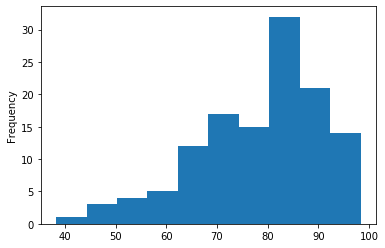

In [7]:
sy_1819_hs['Graduation_Rate_School'].plot(kind='hist')

The distribution is still left skewed, but much less so than before.

In [8]:
from sklearn.dummy import DummyRegressor

dr = DummyRegressor()

grad_rates = sy_1819_hs['Graduation_Rate_School']
cv_feature_set(dr, sy_1819_hs, grad_rates)

##########Training##########
R2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0
RMSE
[12.64955613 12.85187593 12.56582616 12.11517537 12.44453921 12.74372382
 13.16645297 12.97654794 12.88643377 13.1563817 ]
Mean RMSE:  12.755651300234032
Standard Deviation RMSE:  0.30966653287987556


##########Test##########
R2
[-0.01308433 -0.08493853 -0.05953362 -0.00350519 -0.0457211  -0.13351066
 -0.28414457 -0.01757665 -0.00744534 -0.15409314]
-0.08035531355446848
RMSE
[13.70626433 12.03085973 14.38238288 17.34109829 15.45753179 13.02002934
  8.1725891  10.57757517 11.55621239  8.28995062]
Mean RMSE:  12.453449364079827
Standard Deviation RMSE:  2.805137655362657


# Model with Percent Demographics

In [11]:
grad_rates = sy_1819_hs['Graduation_Rate_School']

hs_1819_with_dem_rates = isolate_numeric_rates(sy_1819_hs)
hs_1819_with_dem_rates['Student_Count_Total'] = sy_1819_hs['Student_Count_Total']

/Users/johnmaxbarry/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [12]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
cv_feature_set(lr, hs_1819_with_dem_rates, grad_rates)


##########Training##########
R2
[0.60083039 0.57185952 0.57453089 0.5414736  0.60579386 0.56363545
 0.58767603 0.60641373 0.59119259 0.58895697]
0.5832363032296792
RMSE
[7.99197324 8.40929657 8.19643627 8.20373977 7.81340822 8.41823567
 8.45450299 8.14102605 8.23933436 8.43490333]
Mean RMSE:  8.230285648729431
Standard Deviation RMSE:  0.19999778619747516


##########Test##########
R2
[-0.52678605  0.56680946  0.52708931  0.55664867  0.34557706  0.61313602
  0.04170347  0.08740275  0.3020706  -0.35602309]
0.2157628212160307
RMSE
[16.82617478  7.60209996  9.60866478 11.52632324 12.2281701   7.60638504
  7.05996684 10.01710282  9.61857014  8.98597187]
Mean RMSE:  10.107942956998897
Standard Deviation RMSE:  2.742714708744383
